# Adversarial validation

Ce fichier permet de sélectionner les données du jeu d'entraînement (requêtes) les plus pertienentes i.e. celles qui s'apprichent le plus de l distribution du jeu de test Kaggle.

In [120]:
# pip install catboost

In [121]:
import numpy as np
import pandas as pd
from catboost import Pool, CatBoostClassifier
from catboost.utils import get_roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.rcParams.update({'font.size': 12})

In [122]:
PATH = '.'

#--- read in the data
X_train = pd.read_csv(PATH  + "//pricing_requests_clean_addedFeatures.csv")
X_test  = pd.read_csv(PATH  + "//test_set_cleaned_addedFeatures.csv")
#--- drop target value (price) from the train set
X_train = X_train.drop(['price'], axis=1)
#--- shuffle train set
X_train = X_train.sample(frac = 1)
#--- from X_train, select only dates that are in the Kaggle test set
X_train = X_train[X_train['date'].isin([0,1,2,3,4,5,6,15,16,17,18,19,20,21,34,35,36,37])]
#--- Add columns 
X_train['dataset_label'] = 0 #add column to specify that data from X_train don't belong to Kaggle dataset
X_test['dataset_label'] = 1 #add column to specify that data from X_est belong to Kaggle dataset
target = 'dataset_label'
#--- Specify categorical and numerical variables
cat_cols = ['city', 'language', 'mobile', 'group', 'brand', 'parking', 'pool', 'children_policy', 'hotel_id']
numeric_cols = ['pib','price_m2','nb_tourists','nb_hab_km2', 'avatar_id','request_number', 'request_nb', 'date', 'stock']

In [123]:
def create_adversarial_data(df_train, df_test, cols, N_val=5000):
    """
    Create train and test sets for adversarial validation
    """
    df_master = pd.concat([df_train[cols], df_test[cols]], axis=0)
    adversarial_val = df_master.sample(N_val, replace=False)
    adversarial_train = df_master[
        ~df_master.index.isin(adversarial_val.index)
    ]
    return adversarial_train, adversarial_val

In [124]:
def train_CatBoost(features,cat_cols,adversarial_train,adversarial_test,plot_ROC = False):
    """
    Format data for CatBoostClassifier and train model CatBoostClassifier. 
    It plots the ROC curve if specified.
    
    Input:
    - features (list): all explanatory variables (categorical and numerical)
    - cat_cols (list): categorical xplanatory variables
    - adversarial_train (dataframe): train dataset for adversarial validation
    - adversarial_test (dataframe): test dataset for adversarial validation
    
    Output:
    - model: trained CatBoostClassifier model
    - train_data: adversarial_train formatted for CatBoostClassifier
    - holdout_data: holdout_data formatted for CatBoostClassifier
    """
    # Formatting adversarial training and testing data for catBoost
    train_data = Pool(
        data=adversarial_train[features],
        label=adversarial_train[target],
        cat_features=cat_cols
    )

    holdout_data = Pool(
        data=adversarial_test[features],
        label=adversarial_test[target],
        cat_features=cat_cols
    )

    # fit model CatBoostClassifier
    params = {
        'iterations': 100,
        'eval_metric': 'AUC',
        'od_type': 'Iter',
        'od_wait': 50,
    }
    params.update({"ignored_features": ['avatar_id', 'request_number','hotel_id']})
    model = CatBoostClassifier(**params)
    _ = model.fit(train_data, eval_set=holdout_data,verbose=False)

    # plot ROC curve
    if plot_ROC:
        plt.figure(figsize= (8,8))
        get_roc_curve(model, 
                      train_data,
                      thread_count=-1,
                      plot=True)
        plt.show()
    return model, train_data, holdout_data

In [125]:
def plot_conf_matrix(label,prediction):
    """
    Plots the confusion matrix.
    
    Inputs:
    - label: true label
    - prediction: label predicted by a model
    
    Outputs:
    - plot of the confusion matrix
    """
    
    conf = confusion_matrix(label, prediction)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = [0, 1])

    cm_display.plot()
    plt.show()

<Figure size 800x800 with 0 Axes>

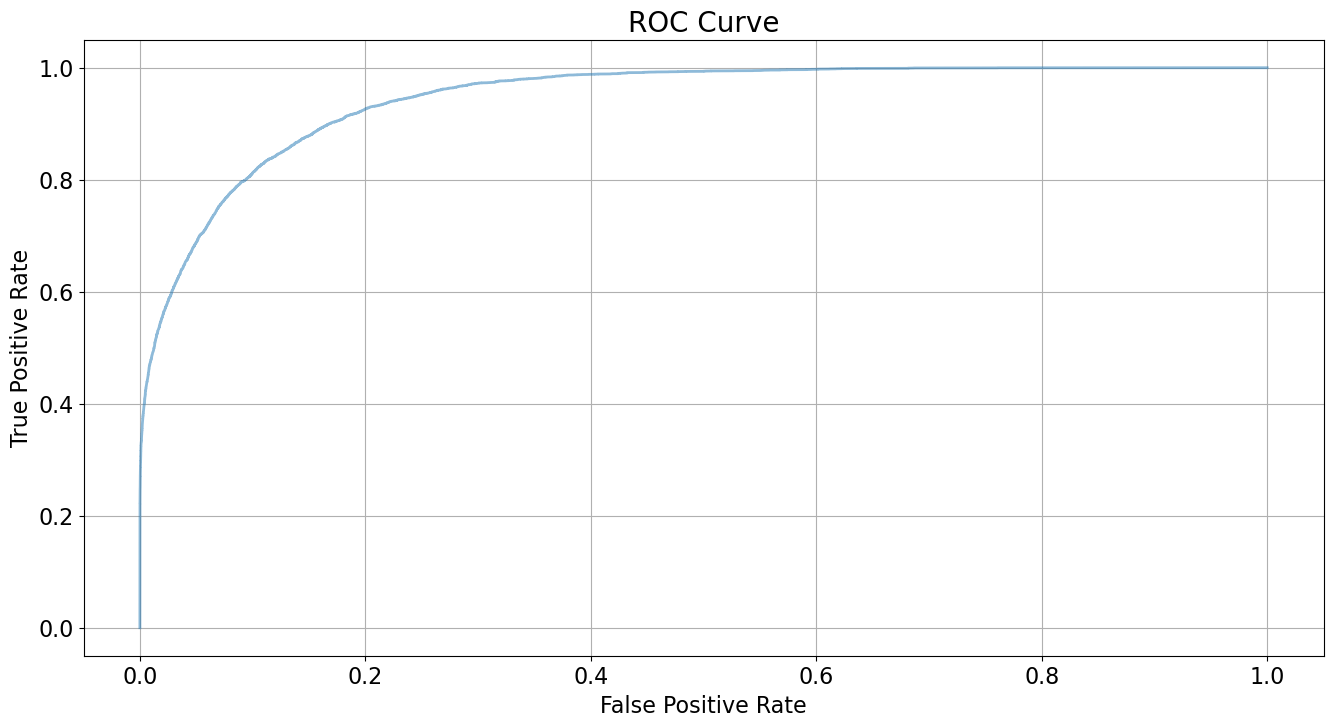

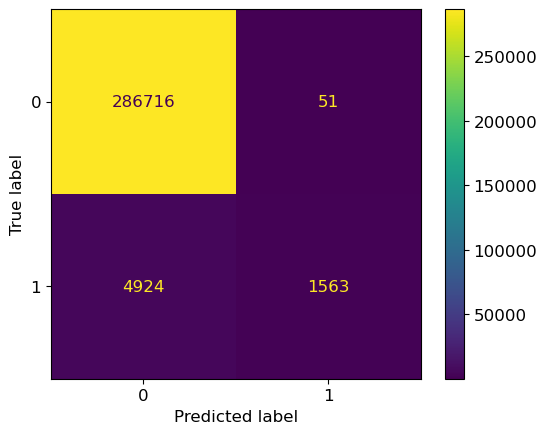

In [128]:
# Adversarial validation sur tout X_train
features = cat_cols + numeric_cols
all_cols = features + [target]

adversarial_train, adversarial_test = create_adversarial_data(X_train, X_test, all_cols)

model,train_data, holdout_data = train_CatBoost(features,cat_cols,adversarial_train,
                                                adversarial_test,plot_ROC = True)

plot_conf_matrix(adversarial_train[target],model.predict(train_data))

In [129]:
features = cat_cols + numeric_cols
all_cols = features + [target]

In [130]:
"""
Ce code performe l'adversarial validation sur plusieurs morceaux
du dataset d'entraînement (requêtes) afin de sélectionner uniquement
les données s'approchant le plus du set de test Kaggle.
"""

# Split the train set into several chunks
n_split = 15000 
# liste de dataframes où chaque dataframe est 
# un morceau de X_train qui s'approche au mieux du set de test kaggle
X_train_keep_l = [] 

for i in range(0,len(X_train), n_split):
    #--- X_train_i est un morceau de X_train
    X_train_i = X_train[i:n_split+i]
    #--- Entraîner un modèle de adversarial validation sur X_train_i
    adversarial_train, adversarial_test = create_adversarial_data(X_train_i, X_test, all_cols)
    model,train_data, holdout_data = train_CatBoost(features,cat_cols,adversarial_train,adversarial_test)
    #--- Définir le subset à garder 
    # ajout d'une colonne prédiction
    adversarial_train['is_in_test'] = model.predict(train_data)  
    # on ne garde que les données de train (requêtes)
    adversarial_train_keep = adversarial_train[adversarial_train['dataset_label'] == 0] 
    # on ne garder parmi les requêtes, que celles qui ont été prédites comme appartenant au set de test
    adversarial_train_keep = adversarial_train_keep[adversarial_train_keep['is_in_test'] == 1] 
    #--- Ajouter le subset à garder à la liste 
    X_train_keep_l.append(adversarial_train_keep)

# concaténation de tous le dataframes qu'on garde
X_train_keep = pd.concat(X_train_keep_l,axis=0)
# on enlève les colonnes ajoutées inutiles à présent
X_train_keep = X_train_keep.drop(["dataset_label","is_in_test"],axis = 1)

<Figure size 800x800 with 0 Axes>

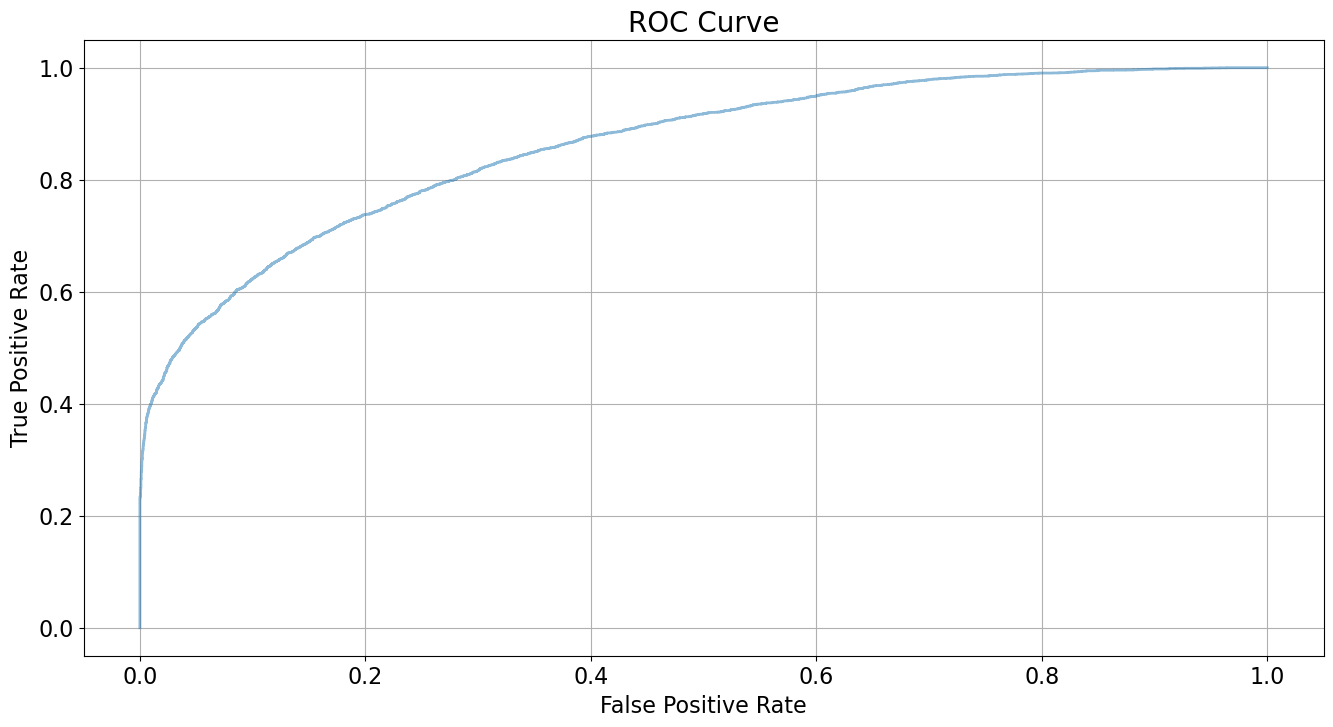

In [132]:
# Re-éxécution de l'adversarial validation avec les nouvelles données X_train_keep
adversarial_train, adversarial_test = create_adversarial_data(X_train_keep, X_test, all_cols)
model,train_data, holdout_data = train_CatBoost(features,cat_cols,adversarial_train,
                                                adversarial_test,plot_ROC = True)

In [138]:
# Enregistrement de la solution 
X_train_keep.to_csv("./pricing_requests_clean_addedFeatures_adv.csv")